In [1]:
# Import libraries
import pandas as pd, numpy as np, os, shutil as sh
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LassoCV
from sklearn.inspection import permutation_importance
from project_1_functions import *

In [2]:
# Settings for plotting and salary grouping
# Plot settings
title_size = 20
label_size = 15
tick_size = 12
chart_alpha = 0.7

# Salary thresholds for outlier identification
very_low_cutoff = 5000
low_cutoff = 50000
high_cutoff = 500000
very_high_cutoff = 2000000

# Salary bands for salary by country chart
salary_bands = {
    '<50k': (-1000000000, 50000),
    '50k-100k': (50000, 100000),
    '100k-200k': (100000, 200000),
    '>200k': (200000, 1000000000)
    }


In [3]:
# Read in raw data
d = read_excel_file('survey_data.xlsx')

## Business Understanding

* We want to understand the factors that drive compensation amongst programmers, so we'll use the following structure for analysis:
    * Dependent variable: ConvertedCompYearly varible
    * Independent variables: Remaining fields (with the exception of CompTotal)
* We will address our task via a few key questions:
    * What does compansation look like in different countries across the world?
    * What does compensation look like for different types of employment and/or education levels?
    * When we apply a more comprehensive model to the data, what are the key factors that drive compensation?

## Data Understanding

* We must delve into the data to prepare it for analysis, which involves cleaning up both catergorical and numerical fields
* At first glance, some potential issues that need to be addressed are:
    * There are appear to be a number of nonsensical values in the compensation data, e.g., individuals who report being full-time employed while making a single-digit annual salary
    * There are a number of countries with a very small number of responses, that may result in spurious results

## Data Preparation

#### Description

* The first cleaning steps involve preparing our dataframe, dropping rows where our target (ConvertedCompYearly) is missing entirely, getting rid of the duplicative CompTotal field, and removing any variables that have the same value for all rows

In [4]:
df_temp = d['data'].set_index('ResponseId').copy()
df_temp = df_temp.dropna(subset=['ConvertedCompYearly'], axis=0)
df_temp = df_temp.drop(['CompTotal', 'Currency'], axis=1)
df_temp = df_temp.loc[:, (df_temp != df_temp.iloc[0]).any()]  # Remove columns with the same value for all rows, as they provide no valuable information by definition

* Removing any variables with more than 10% missing data

In [5]:
threshold=0.1
missing_values = df_temp.isnull().sum()
below_threshold = missing_values/len(df_temp) > threshold
df_temp = df_temp.drop(below_threshold[below_threshold==True].index,axis=1)

* Searching for outlier pay
    * The pay distribution appears to be multimodal, with the left tail clustered around 0 and the right tail effectively uniformly distributed beyond $2mm
    * For the purposes of our analysis, we'll remove these outliers, as they represent a small percentage of the overall dataset and would be better handled with separate modeling to identify them

Number of responses with salary below $5000: 1528
Number of responses with salary above $2000000: 11


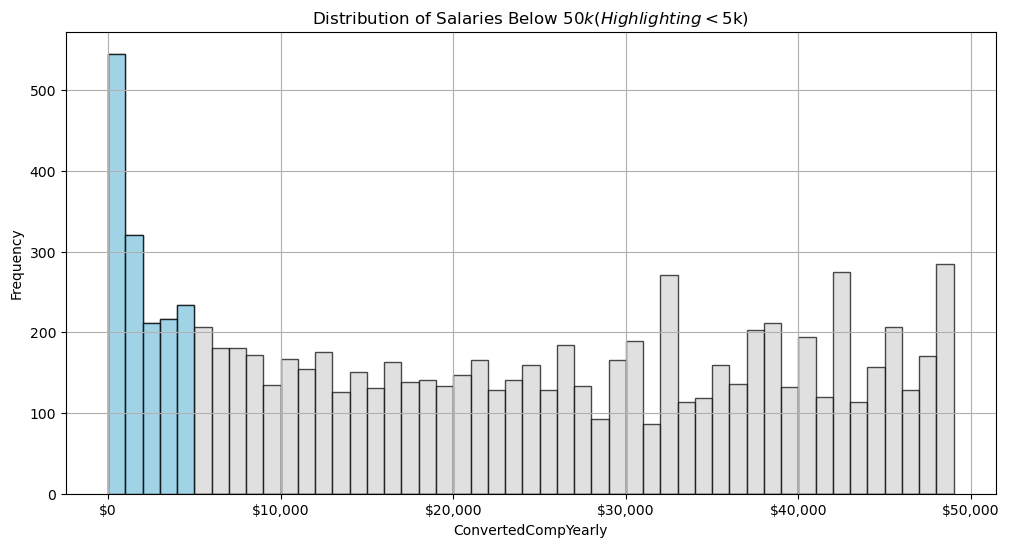

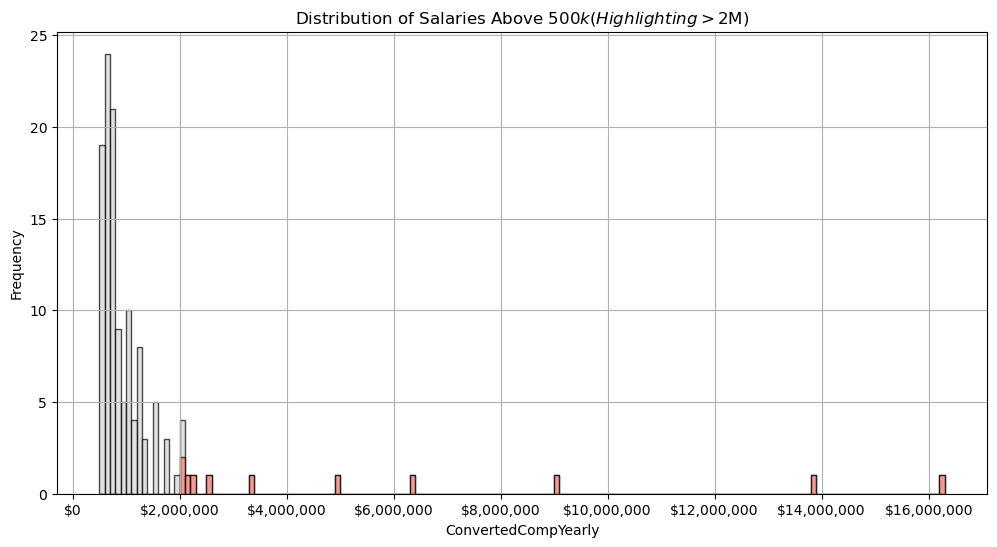

In [6]:
# Print number of very low and high outlier salaries
low_outliers = df_temp[df_temp['ConvertedCompYearly'] < very_low_cutoff]
very_high_outliers = df_temp[df_temp['ConvertedCompYearly'] > very_high_cutoff]
print(f'Number of responses with salary below ${very_low_cutoff}: {low_outliers.shape[0]}')
print(f'Number of responses with salary above ${very_high_cutoff}: {very_high_outliers.shape[0]}')


# Plot all salaries below $50k and highlight the ones below $5k
plt.figure(figsize=(12, 6))
all_low_salaries = df_temp[df_temp['ConvertedCompYearly'] < low_cutoff]
bins = range(0, low_cutoff, 1000)  # Define bin edges
all_low_salaries['ConvertedCompYearly'].plot(kind='hist', bins=bins, color='lightgrey', edgecolor='black', alpha=chart_alpha)
low_outliers['ConvertedCompYearly'].plot(kind='hist', bins=bins, color='skyblue', edgecolor='black', alpha=chart_alpha)
plt.title('Distribution of Salaries Below $50k (Highlighting < $5k)')
plt.xlabel('ConvertedCompYearly')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_fmt))
plt.grid(True)
plt.show()

# Plot all high salaries above $500k and highlight the ones above $2M
plt.figure(figsize=(12, 6))
all_high_salaries = df_temp[df_temp['ConvertedCompYearly'] > high_cutoff]
bins = range(high_cutoff, int(df_temp['ConvertedCompYearly'].max()) + 100000, 100000)  # Define bin edges
all_high_salaries['ConvertedCompYearly'].plot(kind='hist', bins=bins, color='lightgrey', edgecolor='black', alpha=chart_alpha)
very_high_outliers['ConvertedCompYearly'].plot(kind='hist', bins=bins, color='salmon', edgecolor='black', alpha=chart_alpha)
plt.title('Distribution of Salaries Above $500k (Highlighting > $2M)')
plt.xlabel('ConvertedCompYearly')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_fmt))
plt.grid(True)
plt.show()

* Removing outlier responses

In [7]:
# Filter the dataset for outliers
low_salary_outliers = df_temp[df_temp['ConvertedCompYearly'] < very_low_cutoff]
very_high_salary_outliers = df_temp[df_temp['ConvertedCompYearly'] > very_high_cutoff]
df_temp = df_temp[~df_temp.index.isin(low_salary_outliers.index)]
df_temp = df_temp[~df_temp.index.isin(very_high_salary_outliers.index)]

print("Both groups removed from dataset")

Both groups removed from dataset


* Taking stock of low-observation countries included in the dataset
    * Gabon has one observation with a salary of $2,000,000!
    * We will group countries with a very low number of responses into a catch-all categtory called "Other"

In [8]:
filtered_countries = ['Gabon', 'Haiti', 'Antigua and Barbuda']
filtered_df = df_temp[df_temp['Country'].isin(filtered_countries)].copy()
columns_to_display = ['Country', 'Employment', 'ConvertedCompYearly']
filtered_df = filtered_df[columns_to_display]

filtered_df

,Country,Employment,ConvertedCompYearly
ResponseId,,,
2188,Gabon,"Employed, full-time",2000000.0
21746,Antigua and Barbuda,"Independent contractor, freelancer, or self-em...",126120.0
39013,Haiti,"Independent contractor, freelancer, or self-em...",90000.0


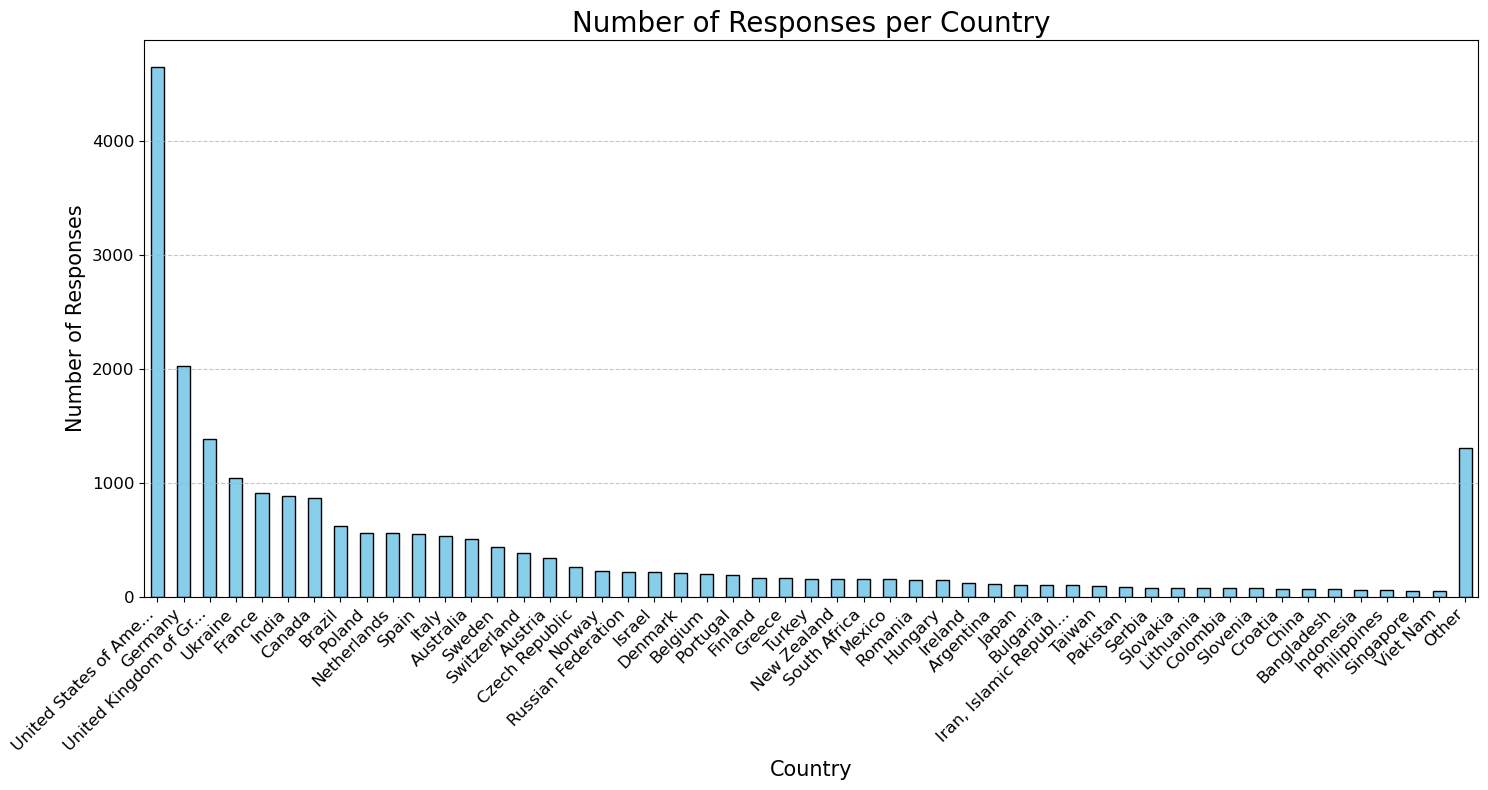

In [9]:
# Threshold for being placed into "Other" bucklet
min_country = 50

# Create "Other" bucket
temp_country = df_temp['Country'].value_counts()
temp_country['Other'] = temp_country[temp_country < min_country].sum()
temp_country = temp_country.drop(temp_country[temp_country < min_country].index)

# Truncate long country names for better readability in the axis
temp_country.index = temp_country.index.map(lambda x: x[:20] + '...' if len(x) > 20 else x)

# Plot results
plt.figure(figsize=(15, 8))
temp_country.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Responses per Country', fontsize=title_size)
plt.xlabel('Country', fontsize=label_size)
plt.ylabel('Number of Responses', fontsize=label_size)
plt.xticks(rotation=45, ha='right', fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid(axis='y', linestyle='--', alpha=chart_alpha)
plt.tight_layout()
plt.show()

* Putting countries with few responses into "Other" bucket

In [10]:
# Identify countries with fewer than min_country responses
country_counts = df_temp['Country'].value_counts()
small_countries = country_counts[country_counts < min_country].index
small_countries_pct = (df_temp['Country'].isin(small_countries).sum() / df_temp.shape[0]) * 100

# Change the country code of these countries to "Other" in df_temp
df_temp.loc[df_temp['Country'].isin(small_countries), 'Country'] = 'Other'

# Print the percentage of the total dataset that these countries represent
print(f'The countries with fewer than {min_country} responses represent {small_countries_pct:.2f}% of the total dataset.')

The countries with fewer than 50 responses represent 5.98% of the total dataset.


* Visualizing salary bands by country

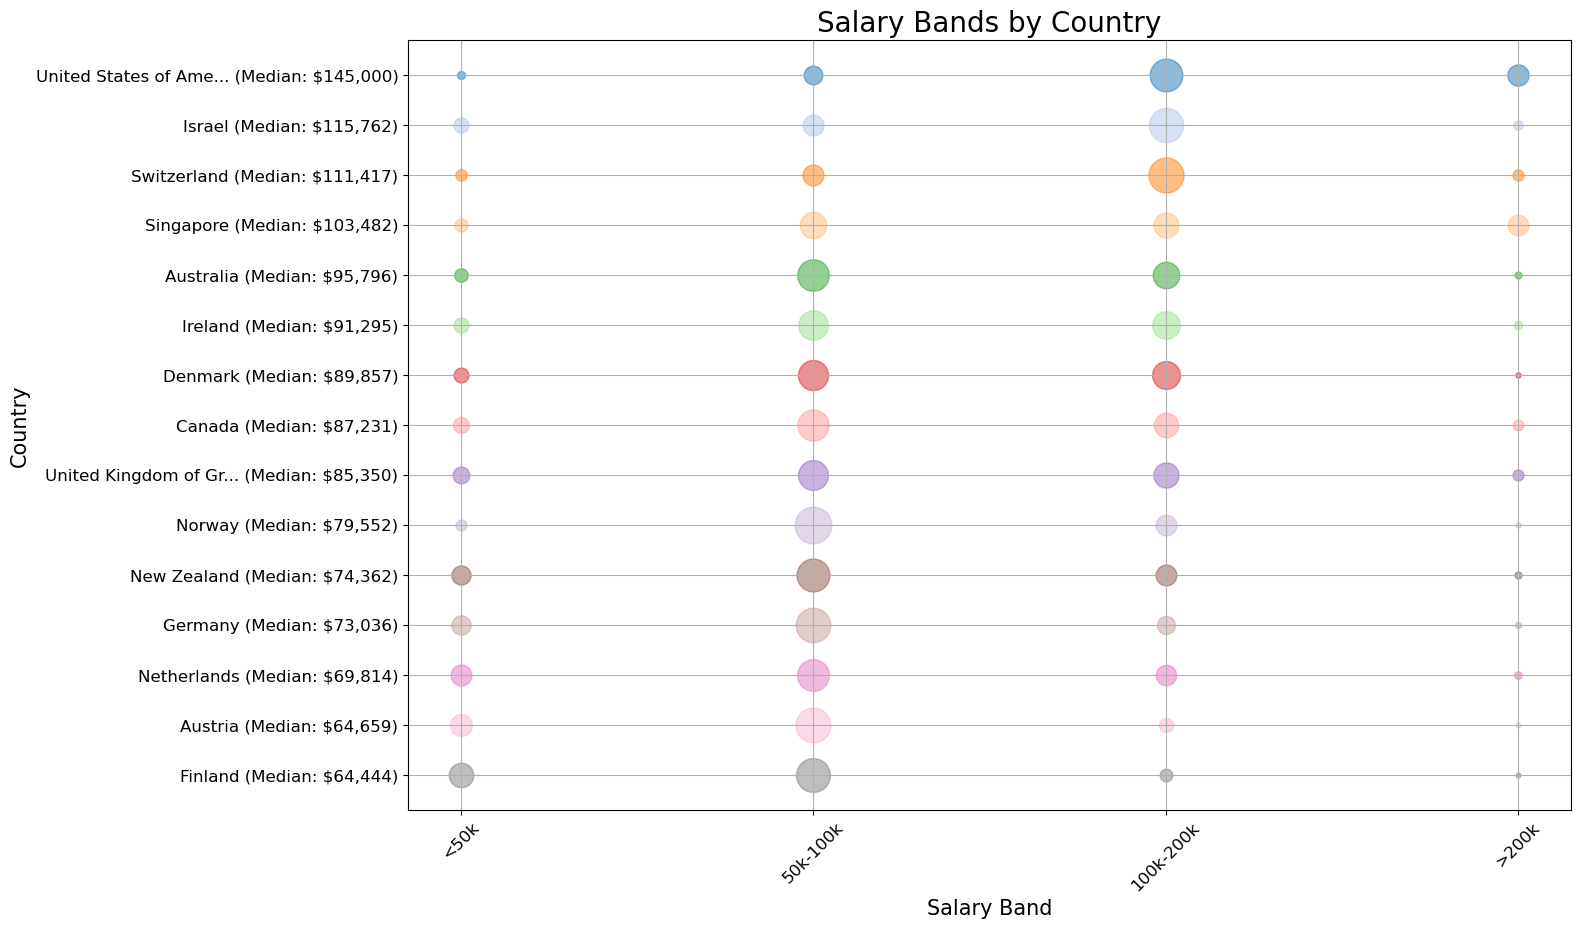

In [11]:
# Making a copy as we're doing some bucketing we don't want to carry through to the actual modeling
df_copy = df_temp.copy()

# Generate salary bands
df_copy['SalaryBand'] = df_copy['ConvertedCompYearly'].apply(categorize_salary,bands=salary_bands)
med_salaries = df_copy.groupby('Country')['ConvertedCompYearly'].median()

# Select the top 15 countries with the highest median salaries
t15 = med_salaries.sort_values(ascending=False).head(15).index
df_t15 = df_copy[df_copy['Country'].isin(t15)]

# Calculate the proportion of each country's salary that falls within each band
weights = df_t15.groupby(['Country', 'SalaryBand']).size().unstack(fill_value=0)
weights = weights.div(weights.sum(axis=1), axis=0)
median_salaries_group = df_t15.groupby('Country')['ConvertedCompYearly'].median()
weights = weights.loc[median_salaries_group.sort_values(ascending=False).index]
weights.index = [f'{country[:20]}... (Median: ${median_salaries_group[country]:,.0f})' if len(country) > 20 else f'{country} (Median: ${median_salaries_group[country]:,.0f})' for country in weights.index]

# Create a bubble plot
plt.figure(figsize=(15, 10))
colors = plt.cm.tab20(range(len(weights.index)))  # Use a colormap for different countries
for i, country in enumerate(weights.index):
    for band in salary_bands:
        plt.scatter(band, country, s=weights.loc[country, band] * 1000, alpha=0.5, color=colors[i])

plt.title('Salary Bands by Country', fontsize=title_size)
plt.xlabel('Salary Band', fontsize=label_size)
plt.ylabel('Country', fontsize=label_size)
plt.xticks(rotation=45, fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid(True)
plt.gca().invert_yaxis() 
plt.show()

* Ensure variables that should be numeric are defined as such

In [12]:
# Convert categorical values in years columns into numeric
columns_to_convert = ['YearsCode', 'YearsCodePro']
for col in columns_to_convert:
    if col in df_temp.columns:
        df_temp[col] = df_temp[col].apply(convert_yrs_exp)
        df_temp[col] = pd.to_numeric(df_temp[col])

* Turn categorical vars into dummies

In [13]:
# Turn categorical columns into dummies
categorical = df_temp.select_dtypes(include=['object']).columns
for col in categorical:
    df_temp = gen_dummies(df_temp, col)

* Distribution by employment status

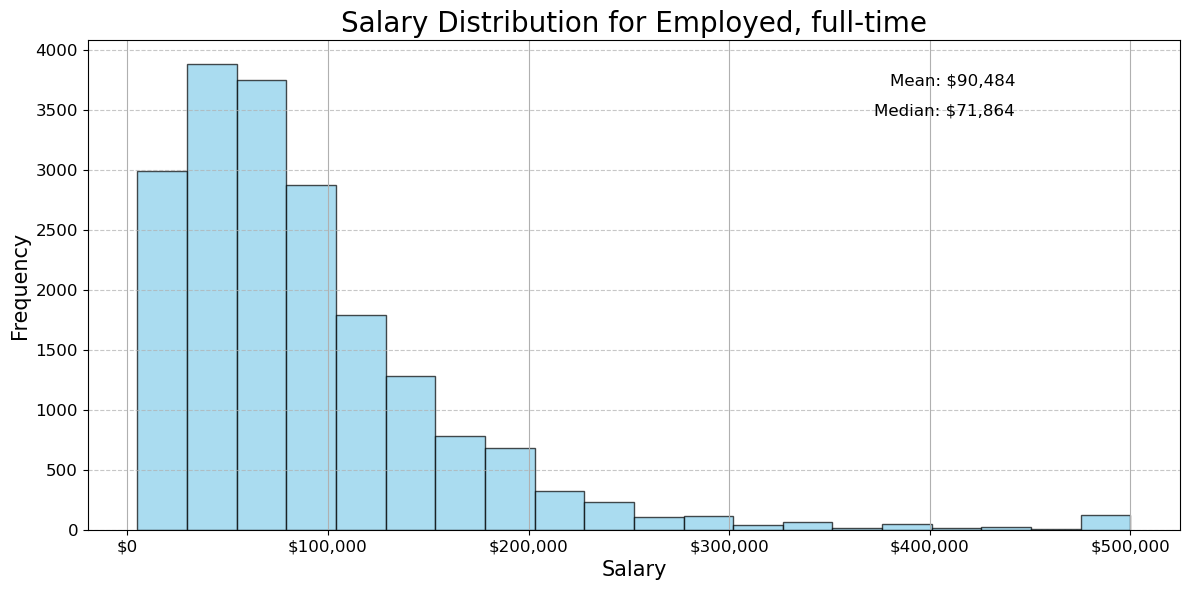

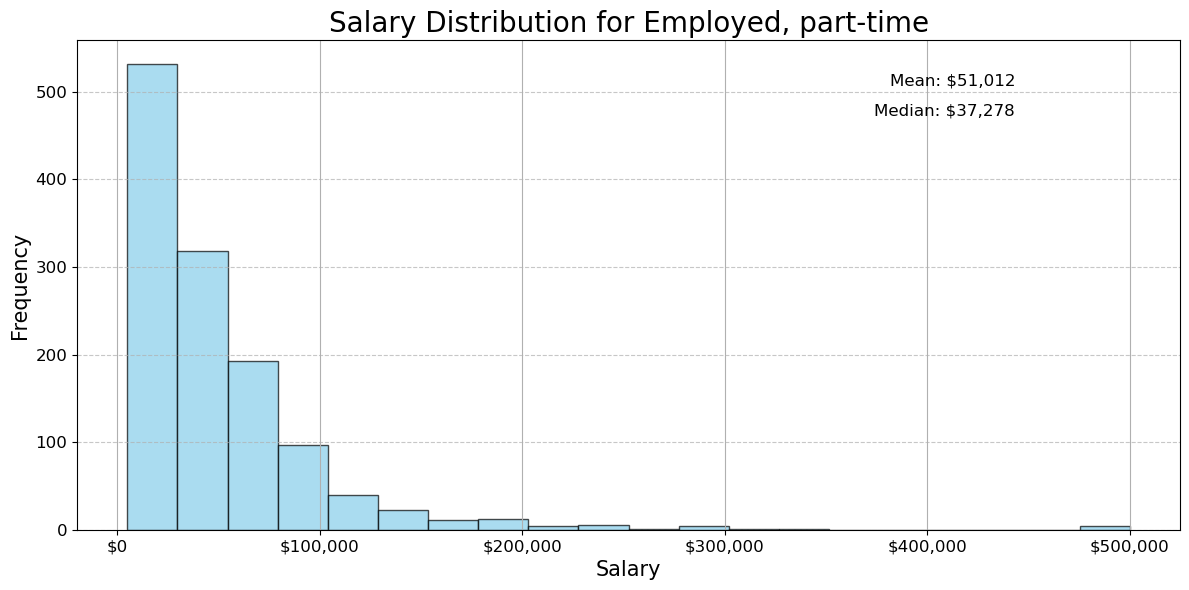

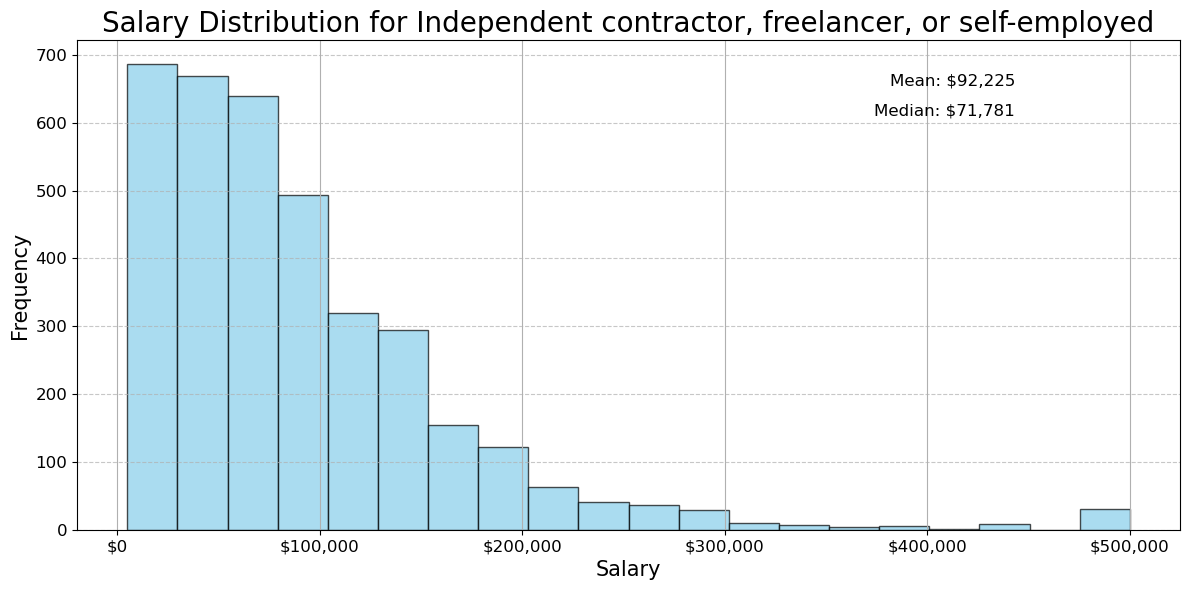

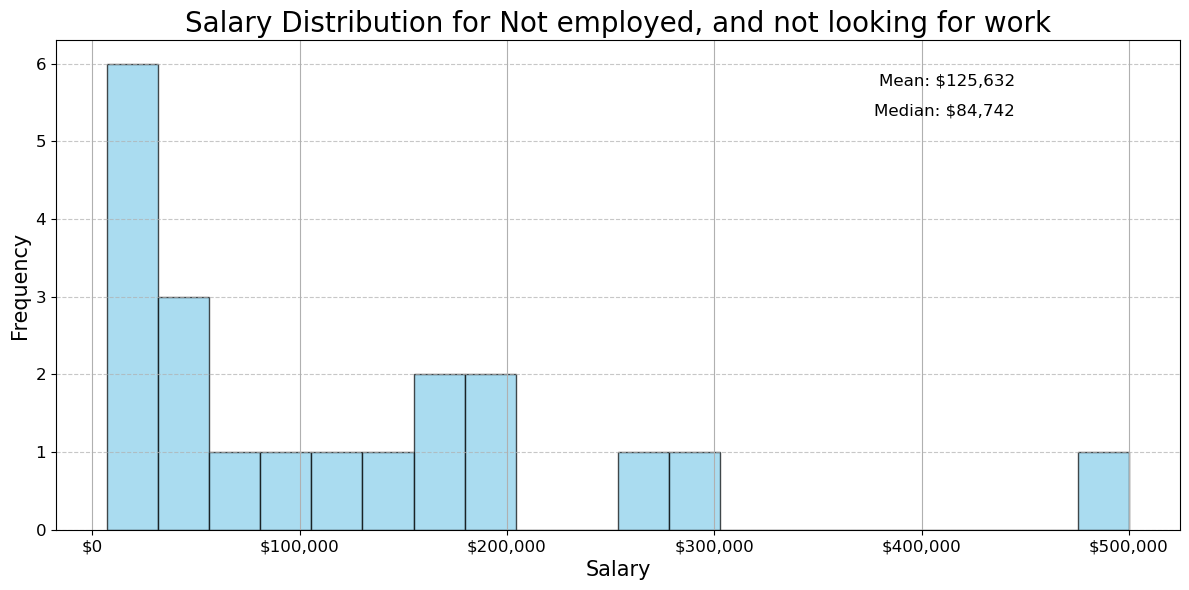

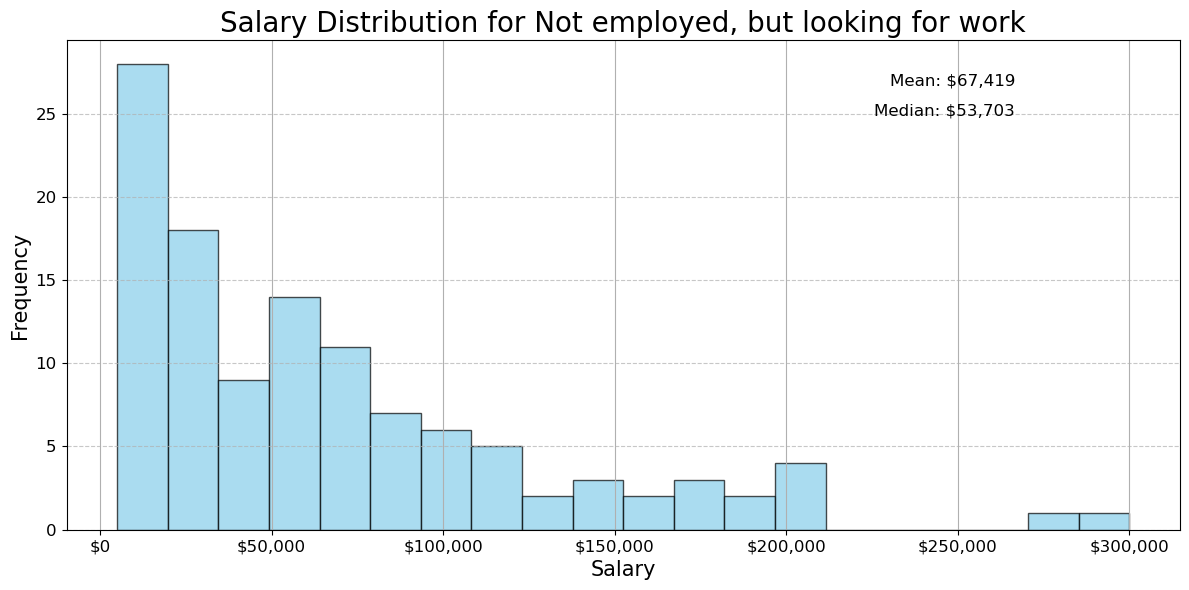

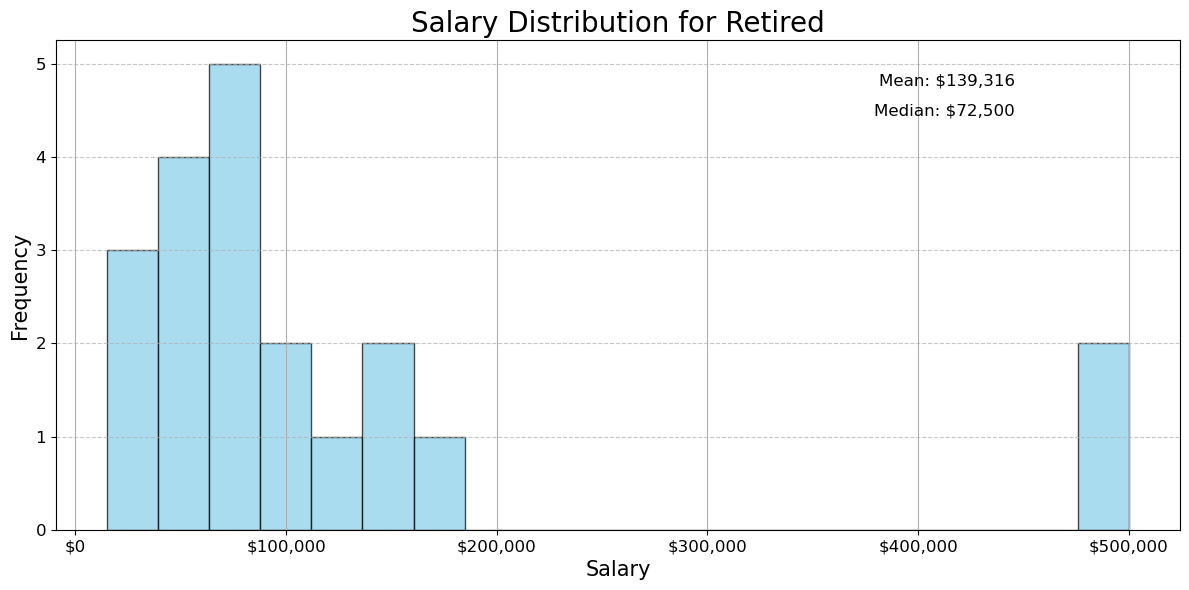

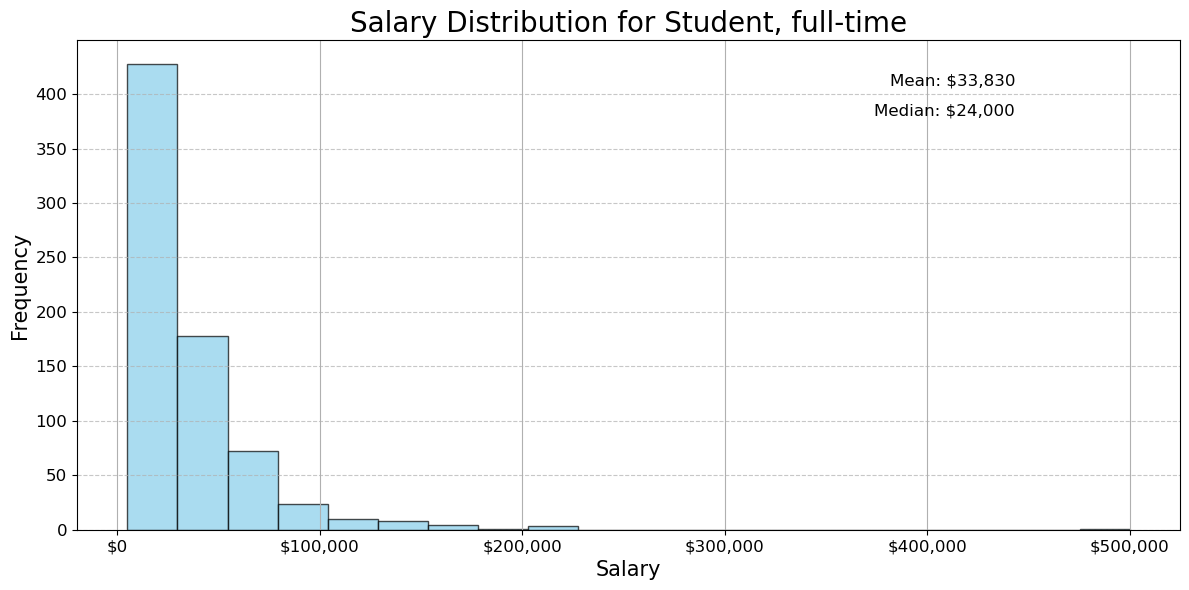

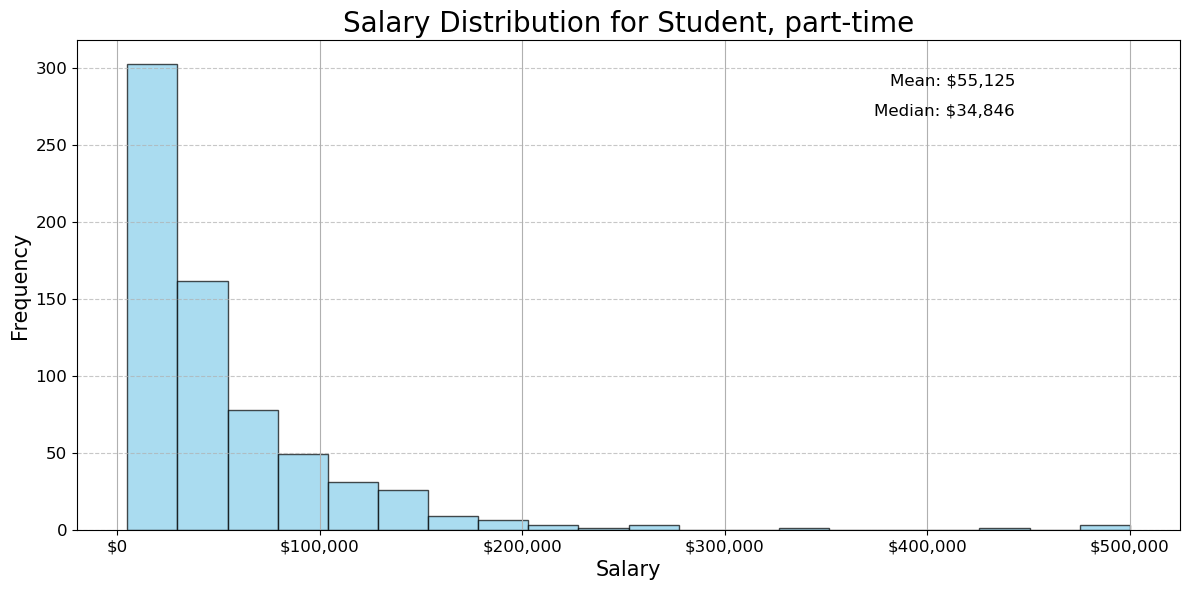

In [14]:
search_var = 'Employment'
plot_var = 'ConvertedCompYearly'

# Columns are the variables that contain the search term (since dummies were tagged with this as a prefix)
search_cols = [col for col in df_temp.columns if search_var in col]
upper_bound = high_cutoff

# Plot results
for col in search_cols:
    plt.figure(figsize=(12, 6))
    subset = df_temp[df_temp[col] == 1][plot_var]
    mean = subset.mean()
    median = subset.median()
    
    # Group salaries above $500k into a bucket for better graph legibility
    subset = subset.apply(lambda x: x if x <= upper_bound else upper_bound)
    subset.hist(bins=20, color='skyblue', edgecolor='black', alpha=chart_alpha)
    
    plt.title(f'Salary Distribution for {col.replace(search_var + "_", "")}', fontsize=title_size)
    plt.xlabel('Salary', fontsize=label_size)
    plt.ylabel('Frequency', fontsize=label_size)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_fmt))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=chart_alpha)
    plt.figtext(0.85, 0.85, f'Mean: {currency_fmt(mean, None)}', fontsize=tick_size, ha='right')
    plt.figtext(0.85, 0.80, f'Median: {currency_fmt(median, None)}', fontsize=tick_size, ha='right')
    plt.tight_layout()
    plt.show()

* Distribution by education level
    * Interestingly, education isn't as related to the distribution of income as would be expected, at leaset by this high-level view
    * Post-secondary education has a similar median/mean outcome as a bachelor's degree but does appear to have more favorable tails

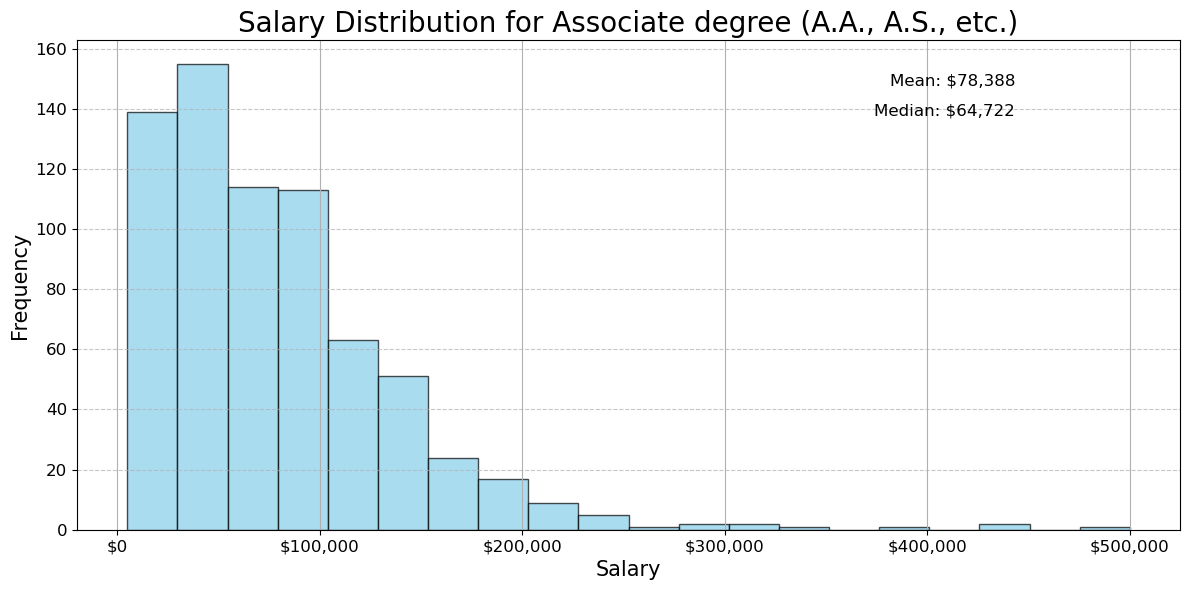

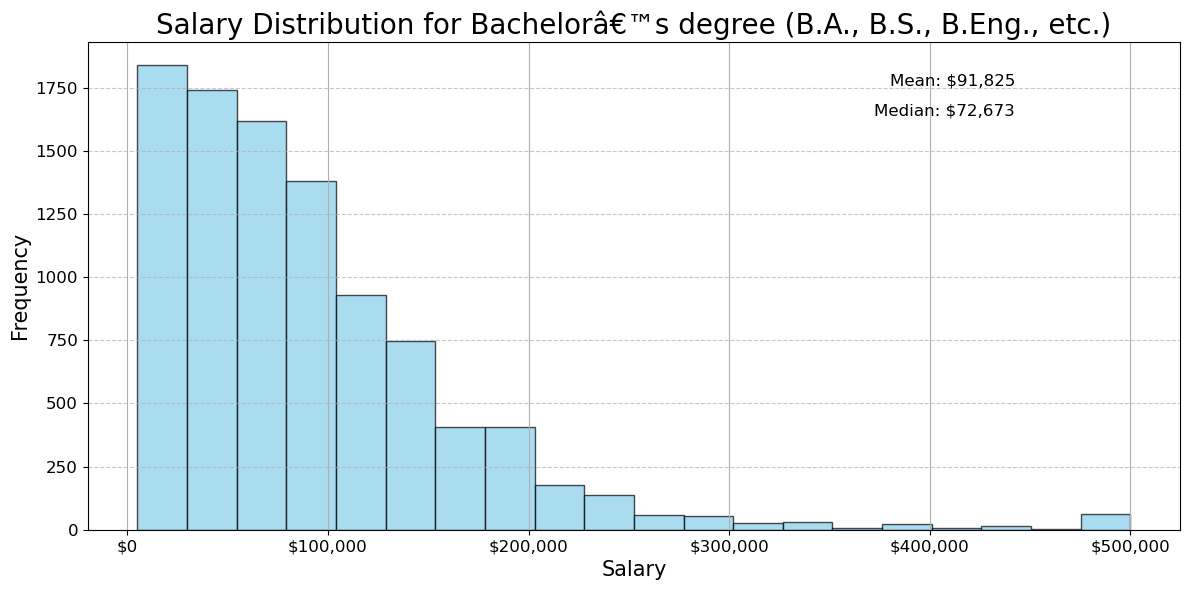

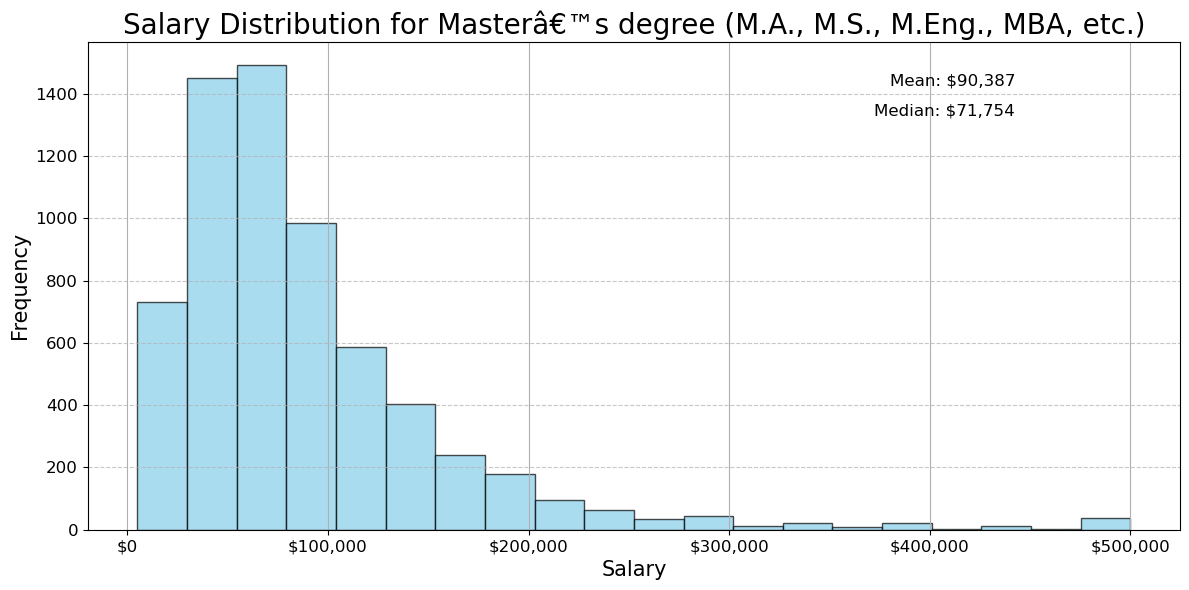

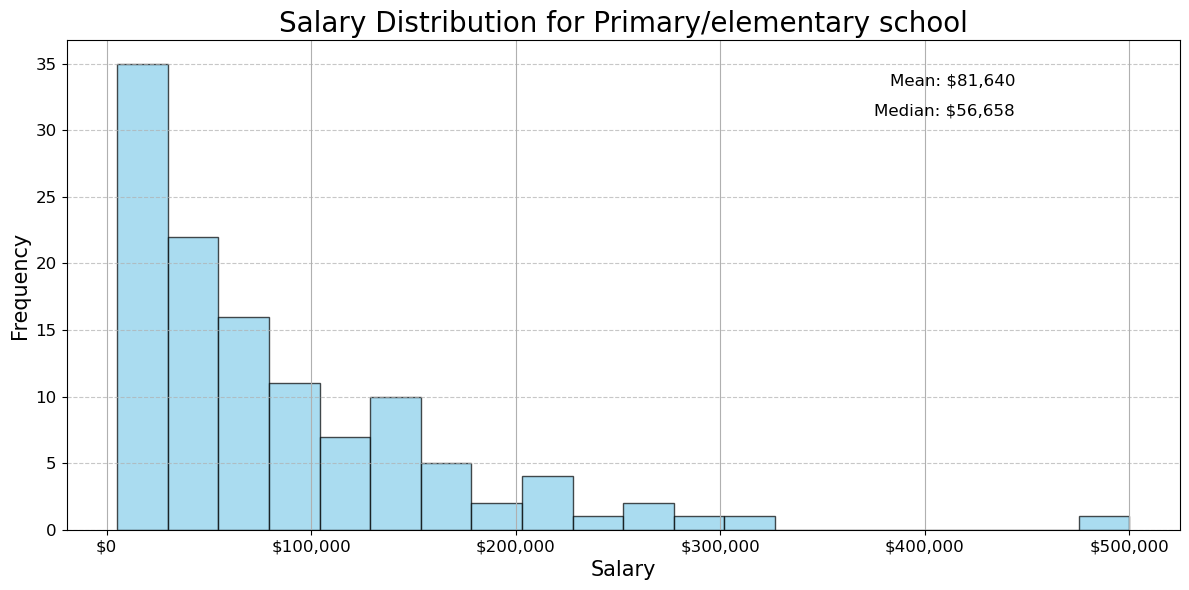

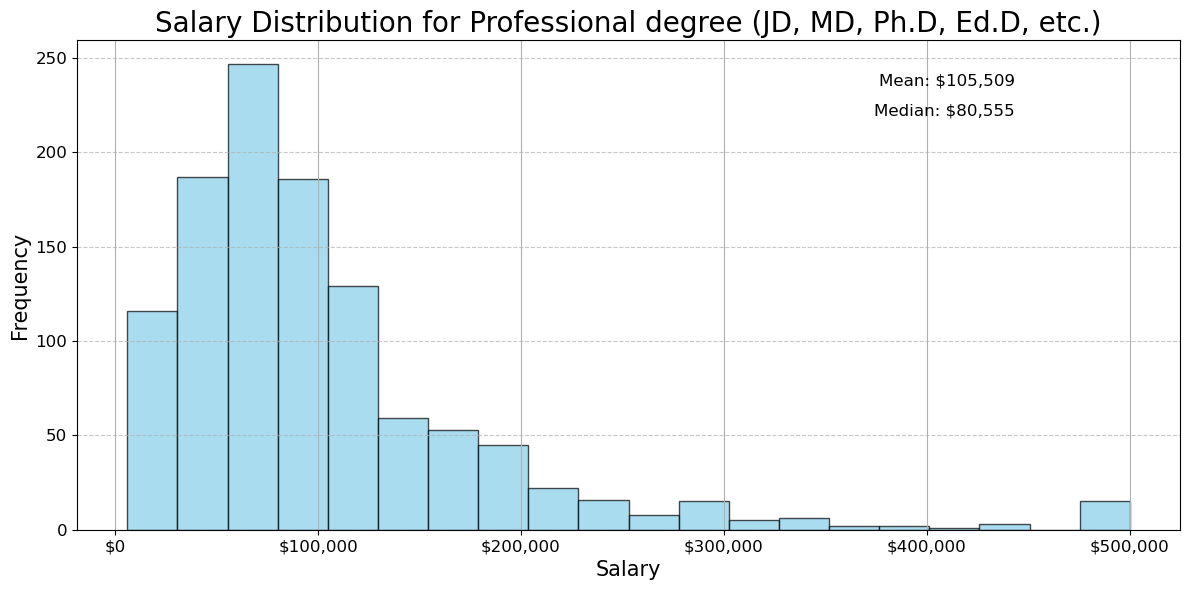

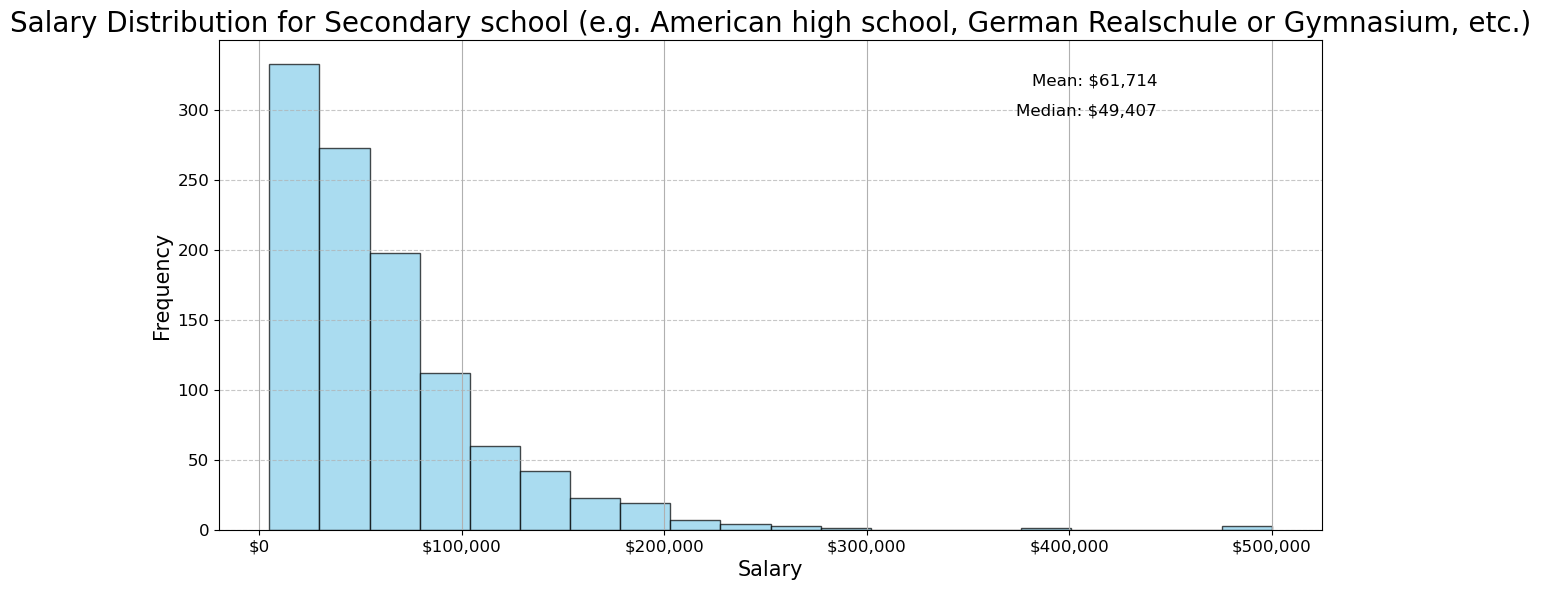

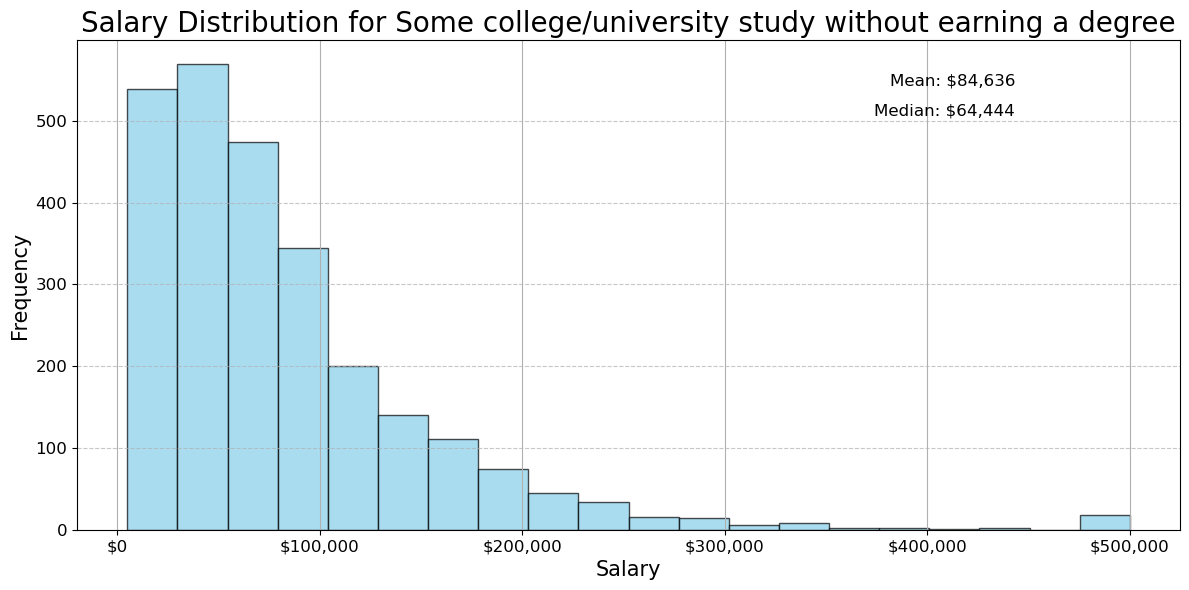

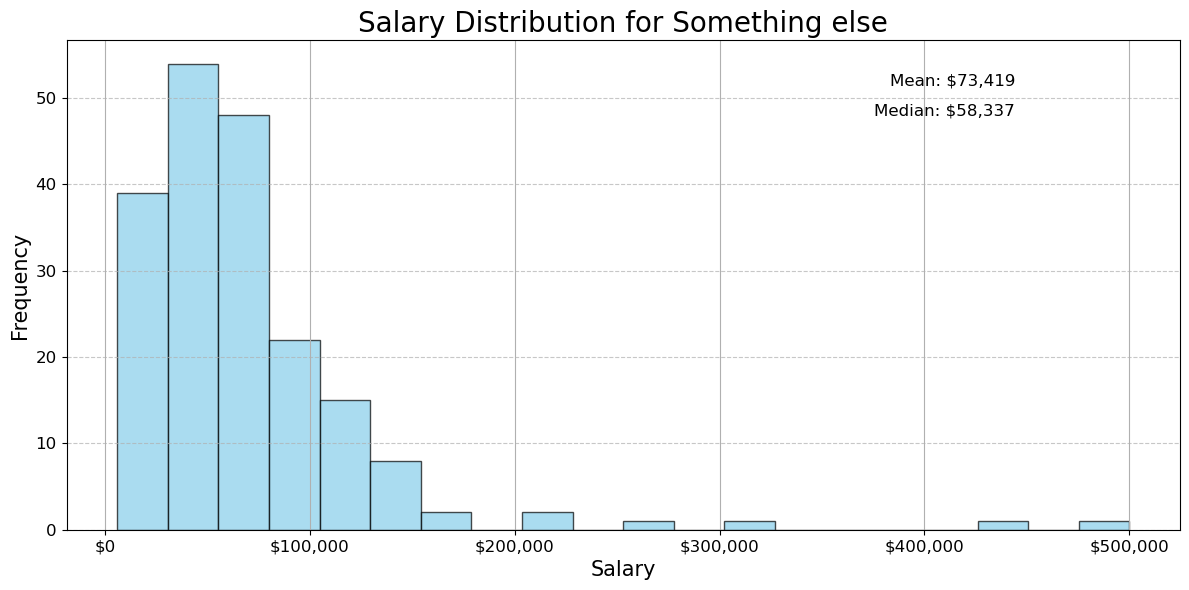

In [15]:
search_var = 'EdLevel'
plot_var = 'ConvertedCompYearly'

# Columns are the variables that contain the search term (since dummies were tagged with this as a prefix)
search_cols = [col for col in df_temp.columns if search_var in col]
upper_bound = high_cutoff

# Plot results
for col in search_cols:
    plt.figure(figsize=(12, 6))
    subset = df_temp[df_temp[col] == 1][plot_var]
    mean = subset.mean()
    median = subset.median()
    
    # Group salaries above $500k into a bucket for better graph legibility
    subset = subset.apply(lambda x: x if x <= upper_bound else upper_bound)
    subset.hist(bins=20, color='skyblue', edgecolor='black', alpha=chart_alpha)
    
    plt.title(f'Salary Distribution for {col.replace(search_var + "_", "")}', fontsize=title_size)
    plt.xlabel('Salary', fontsize=label_size)
    plt.ylabel('Frequency', fontsize=label_size)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_fmt))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=chart_alpha)
    plt.figtext(0.85, 0.85, f'Mean: {currency_fmt(mean, None)}', fontsize=tick_size, ha='right')
    plt.figtext(0.85, 0.80, f'Median: {currency_fmt(median, None)}', fontsize=tick_size, ha='right')
    plt.tight_layout()
    plt.show()

* The variables most correlated with pay are generally in-line with what we'd expect to see

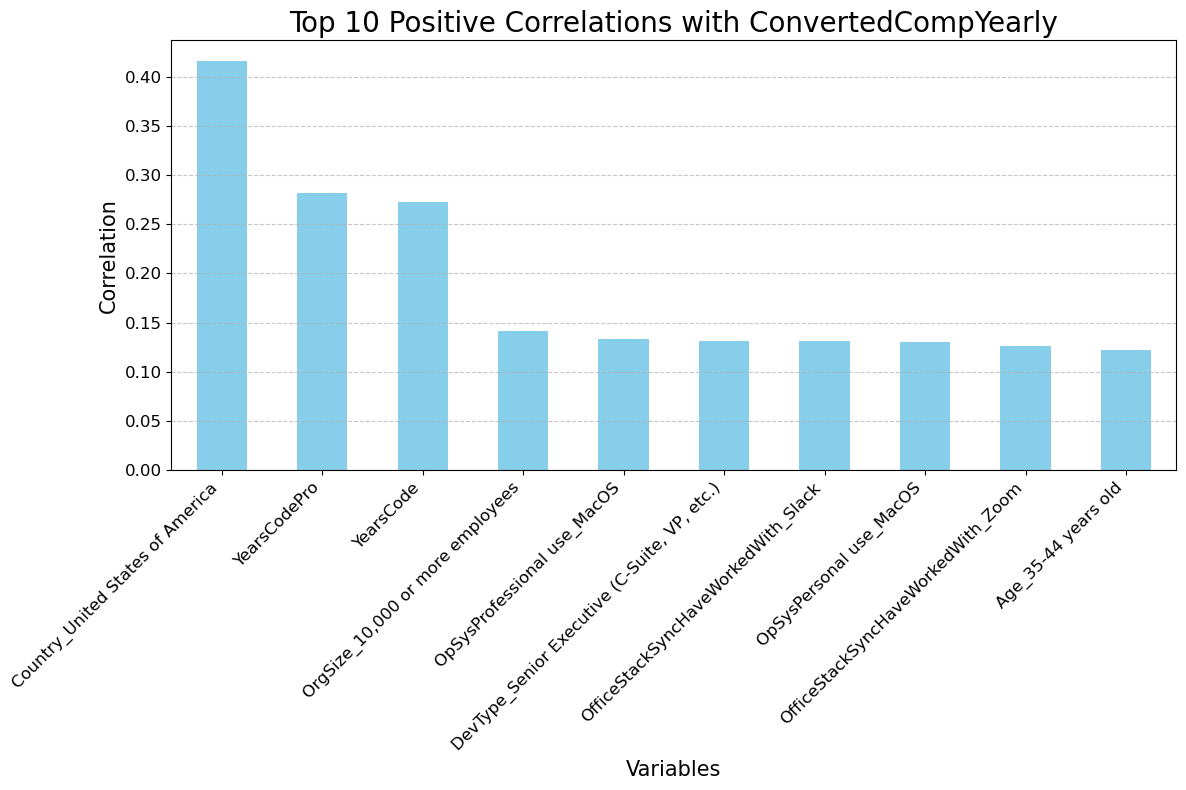

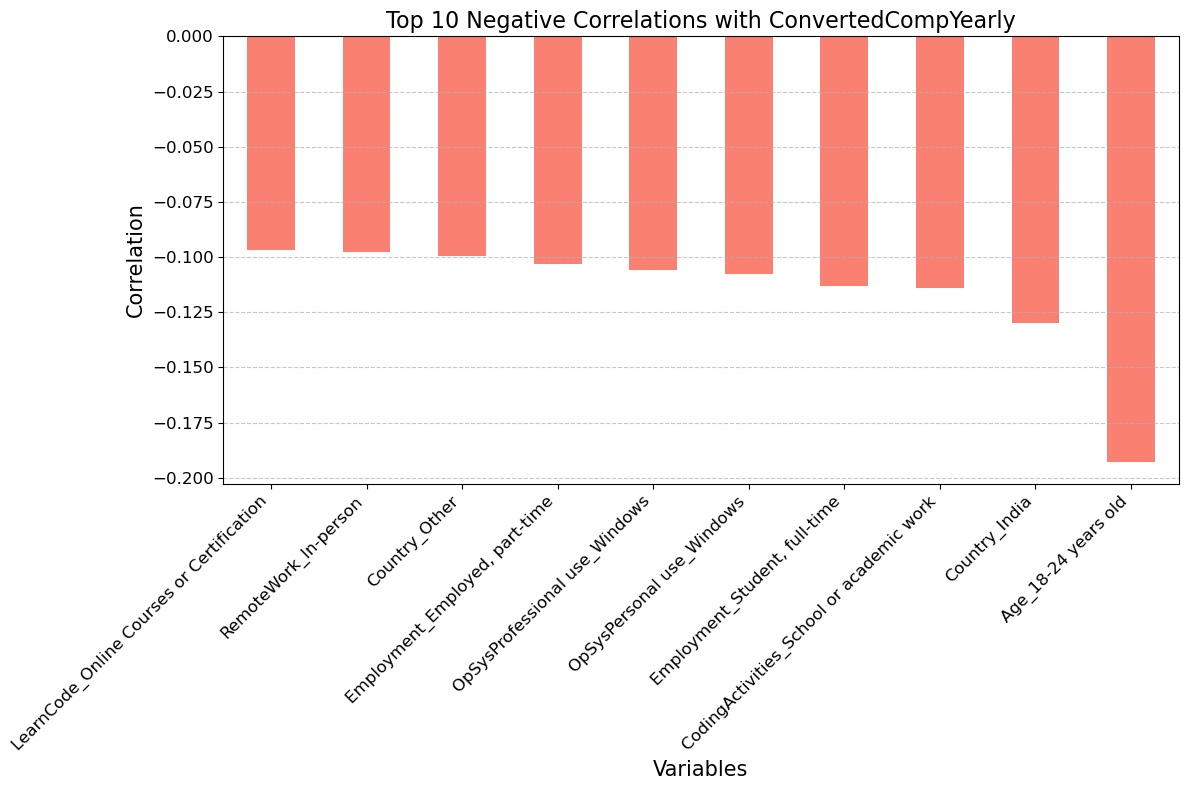

In [16]:
choose_y = 'ConvertedCompYearly'
top_num = 10

# Extract the correlations with y var (i.e., just the ones we care about)
corr_mat = df_temp.corr()
corrs = corr_mat[choose_y].drop(choose_y)
corr_sort = corrs.sort_values(ascending=False)

# Select the top correlations
t_pos = corr_sort.head(top_num)
t_neg = corr_sort.tail(top_num)

# Plot most pos corrs
plt.figure(figsize=(12, 8))
t_pos.plot(kind='bar', color='skyblue')
plt.title(f'Top {top_num} Positive Correlations with {choose_y}', fontsize=title_size)
plt.xlabel('Variables', fontsize=label_size)
plt.ylabel('Correlation', fontsize=label_size)
plt.xticks(rotation=45, ha='right', fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid(axis='y', linestyle='--', alpha=chart_alpha)
plt.tight_layout()
plt.show()

# Plot most neg corrs
plt.figure(figsize=(12, 8))
t_neg.plot(kind='bar', color='salmon')
plt.title(f'Top {top_num} Negative Correlations with {choose_y}', fontsize=16)
plt.xlabel('Variables', fontsize=label_size)
plt.ylabel('Correlation', fontsize=label_size)
plt.xticks(rotation=45, ha='right', fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid(axis='y', linestyle='--', alpha=chart_alpha)
plt.tight_layout()
plt.show()

* We've explored the data, and it's time for the final preparatory step before modeling - imputing missing values

In [17]:
random_seed = 123

# We'll exclude our target variable, as we wouldn't want to impute values for that
y_variable = 'ConvertedCompYearly'
excl_cols = [y_variable]

# Identify columns with missing values (these are the ones we'd like to impute)
cols_missing = df_temp.columns[df_temp.isnull().any()].tolist()
cols_missing = [col for col in cols_missing if col not in excl_cols]

# Identify continuous variables (excluding binary variables), as we'll want to standardize these
cont_vars = df_temp.select_dtypes(include=[np.number]).columns.tolist()
binary_vars = [col for col in df_temp.columns if set(df_temp[col].dropna().unique()) <= {0, 1}]
cont_vars = [col for col in cont_vars if col not in binary_vars + excl_cols]

# Prep dataset - we'll use df_model from here on out
df_model = df_temp.copy()
scaler = StandardScaler()
df_model[cont_vars] = scaler.fit_transform(df_model[cont_vars])

# Impute missing values 
impute_summary = {}
for col in cols_missing:
    df_model, num_imputed, best_alpha, r2 = impute_missing_vals(df_model, col,columns_to_exclude=excl_cols,random_seed=random_seed)
    impute_summary[col] = (num_imputed, best_alpha, r2)

# Double check no missing values remain (bonus points if you get the MissingNo reference lol)
missingno = df_model.isnull().sum().sum()
print(f'Total missing values after imputation: {missingno}')

# Results summary
print("Summary of imputed values:")
for col, (num_imputed, best_alpha, r2) in impute_summary.items():
    if best_alpha is not None and r2 is not None:
        print(f'{col}: {num_imputed} values imputed, alpha={best_alpha:.4f}, R²={r2:.2f}')
    else:
        print(f'{col}: {num_imputed} values imputed')

Total missing values after imputation: 0
Summary of imputed values:
YearsCode: 39 values imputed, alpha=0.0004, R²=0.72
YearsCodePro: 76 values imputed, alpha=0.0009, R²=0.88


## Modeling

* Comparing different modeling approaches, we can see that performance is fairly strong around the center of the distribution, but extremely high salaries are difficult to predict with the data we have available
* The neural network has the most attractive profile of its residuals; while it struggles to predict the exceedingly high salaries (as do the rest of the models), it also does not errantly predict extremely high salaries where they do not exist

Gradient Boosted Tree R²: 0.30


c:\Users\njhpe\anaconda3\envs\prod\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network R²: 0.34
Lasso Regression R²: 0.34


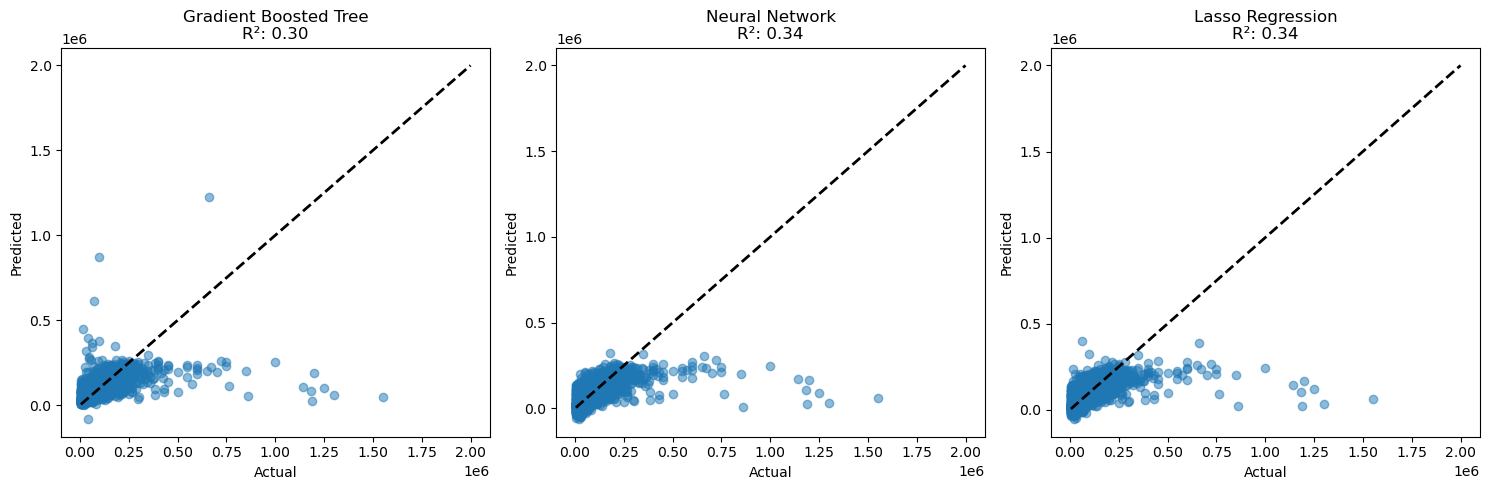

In [18]:
# Split the data into training and teseting sets
X = df_model.drop(columns=excl_cols)
y = df_model[y_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Run boosted tree
gbr = GradientBoostingRegressor(random_state=random_seed)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
r2_gbr = r2_score(y_test, y_pred_gbr)
print(f'Gradient Boosted Tree R²: {r2_gbr:.2f}')

# Run neural net
nn = MLPRegressor(random_state=random_seed, max_iter=1000)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
r2_nn = r2_score(y_test, y_pred_nn)
print(f'Neural Network R²: {r2_nn:.2f}')

# Run lasso
lasso = LassoCV(cv=KFold(n_splits=20, shuffle=True, random_state=random_seed), random_state=random_seed)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f'Lasso Regression R²: {r2_lasso:.2f}')

# Residual plots
plt.figure(figsize=(15, 5))

# Tree
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_gbr, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Gradient Boosted Tree\nR²: {r2_gbr:.2f}')

# Neural net
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Neural Network\nR²: {r2_nn:.2f}')

# Lasso
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Lasso Regression\nR²: {r2_lasso:.2f}')

plt.tight_layout()
plt.show()

## Evaluation

* Analyzing feature importance by model, we can see that years of experience and working in the US are consistently the top factors driving higher compensation

In [19]:
# Variable importance for tree
tree_importance = gbr.feature_importances_
tree_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': tree_importance})
tree_importance_df = tree_importance_df.sort_values(by='Importance', ascending=False)

# Variable importance for neural net using permutation importance
nn_importance = permutation_importance(nn, X_test, y_test, n_repeats=10, random_state=random_seed)
nn_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': nn_importance.importances_mean})
nn_importance_df = nn_importance_df.sort_values(by='Importance', ascending=False)

# Variable importance for lasso
lasso_importance = np.abs(lasso.coef_)
lasso_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': lasso_importance})
lasso_importance_df = lasso_importance_df.sort_values(by='Importance', ascending=False)

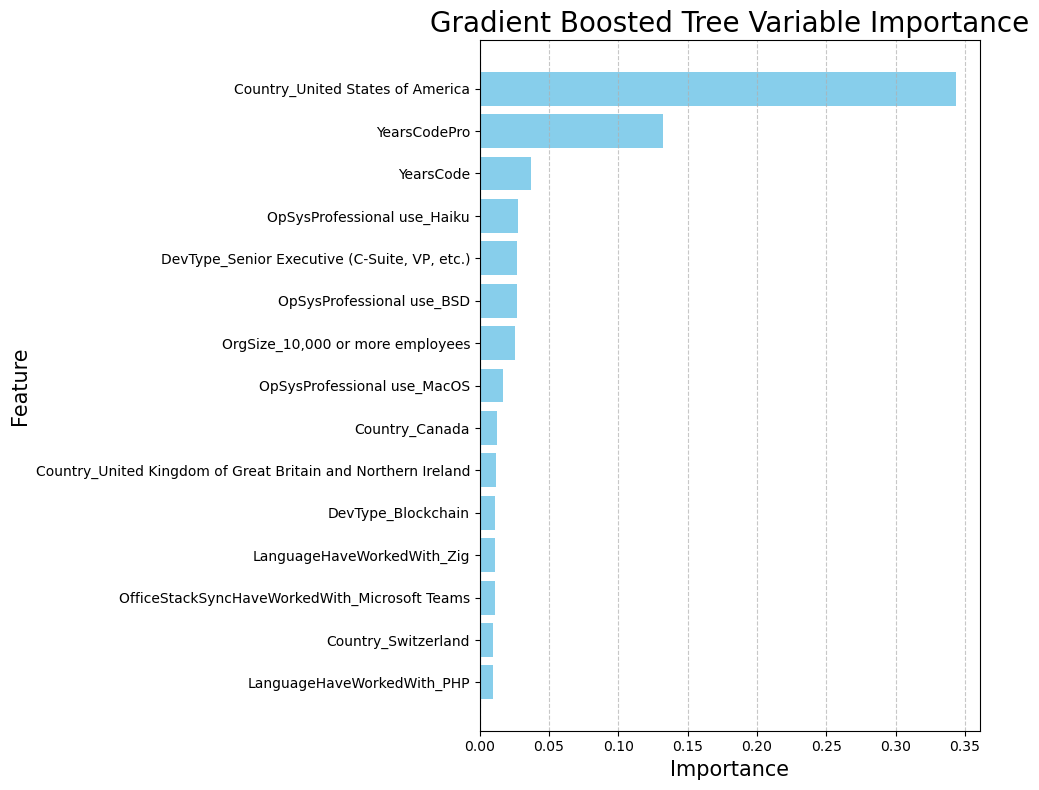

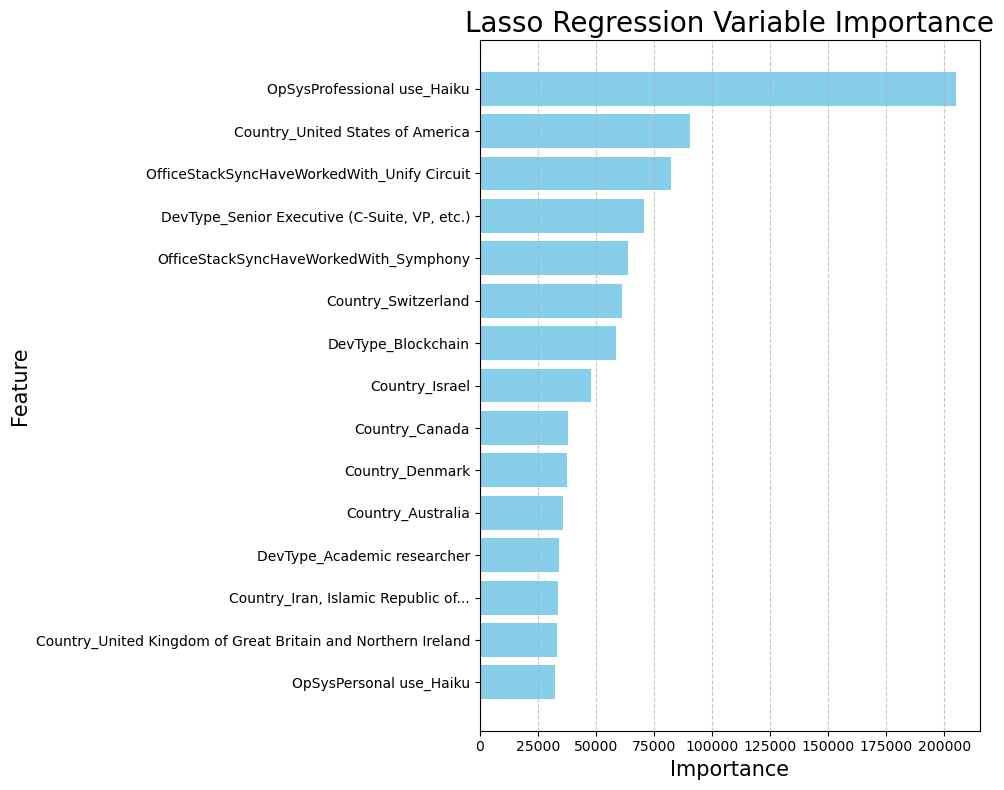

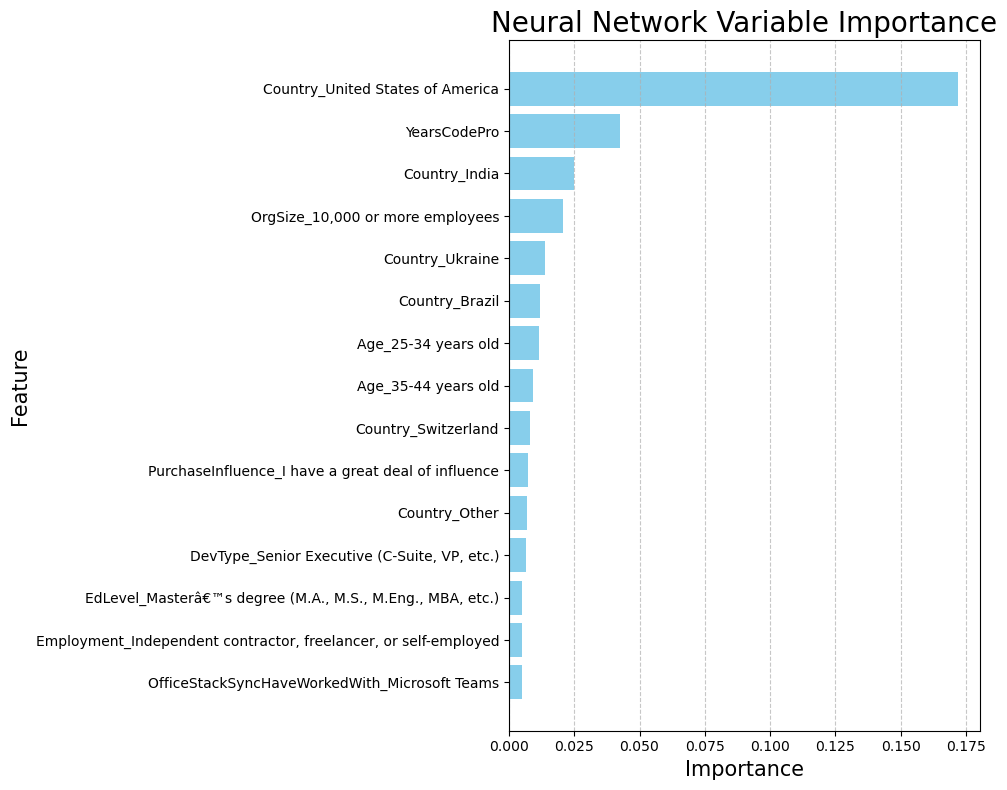

In [20]:
top_features = 15

# Plot Gradient Boosted Tree variable importance
plt.figure(figsize=(10, 8))
plt.barh(tree_importance_df['Feature'].head(top_features), tree_importance_df['Importance'].head(top_features), color='skyblue')
plt.xlabel('Importance', fontsize=label_size)
plt.ylabel('Feature', fontsize=label_size)
plt.title('Gradient Boosted Tree Variable Importance', fontsize=title_size)
plt.grid(axis='x', linestyle='--', alpha=chart_alpha)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot Lasso Regression variable importance
plt.figure(figsize=(10, 8))
plt.barh(lasso_importance_df['Feature'].head(top_features), lasso_importance_df['Importance'].head(top_features), color='skyblue')
plt.xlabel('Importance', fontsize=label_size)
plt.ylabel('Feature', fontsize=label_size)
plt.title('Lasso Regression Variable Importance', fontsize=title_size)
plt.grid(axis='x', linestyle='--', alpha=chart_alpha)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot Neural Network variable importance
plt.figure(figsize=(10, 8))
plt.barh(nn_importance_df['Feature'].head(top_features), nn_importance_df['Importance'].head(top_features), color='skyblue')
plt.xlabel('Importance', fontsize=label_size)
plt.ylabel('Feature', fontsize=label_size)
plt.title('Neural Network Variable Importance', fontsize=title_size)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Deployment

* We have derived the following key findings to use going forward:
    * Simply put, the US has the best salary scaling for programming jobs relative to other countries; if you can take a programming job in the US, this is the best thing you can do to maximize your comp given the rest of your skillset
    * Years of professional experience beats year of experience overall; to all hobbyists - switch to a programming job as quickly as you can
    * Work for a large organization if you can
    * Education might not matter as much as you think it does, but only if you can still meet the steps above

* Our deployment consists of a summary of our findings in a Medium blog post paired with a recommendation for how one might optimize income